In [1]:
from keras.models import Sequential

Using TensorFlow backend.


In [14]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import pandas_datareader as web

In [38]:
# сток quote
df = pd.read_csv('AAPL.csv')

In [39]:
df.shape

(1048, 7)

In [40]:
df['Date']

0       2012-01-03
1       2012-01-04
2       2012-01-05
3       2012-01-06
4       2012-01-09
           ...    
1043    2016-02-26
1044    2016-02-29
1045    2016-03-01
1046    2016-03-02
1047    2016-03-03
Name: Date, Length: 1048, dtype: object

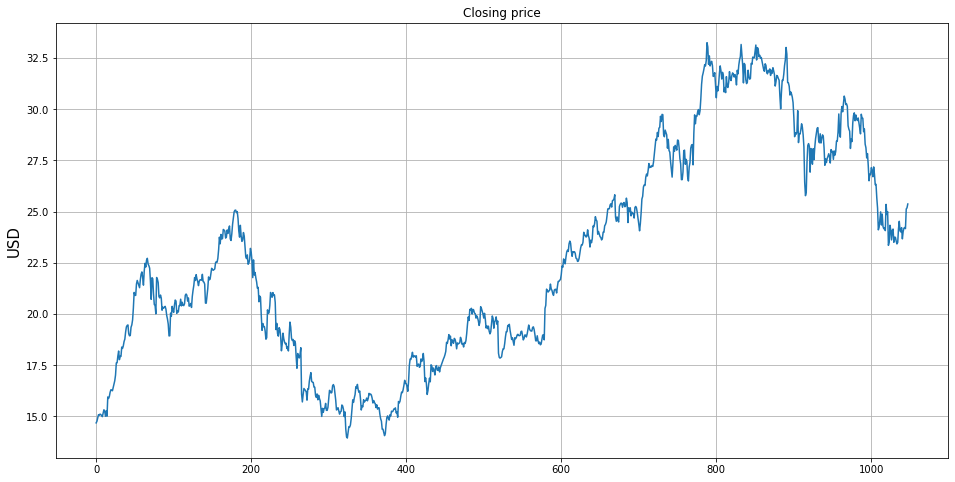

In [41]:
data = df.filter(['Close']) # попробуем работать с ценой закрытия дня
plt.figure(figsize=(16,8))
plt.title('Closing price')
plt.ylabel('USD',fontsize=15)
plt.grid()
plt.plot(data)
plt.show()

In [42]:
dataset = data.values

training_data_len = math.ceil(len(dataset) * .8)

In [43]:
# скалируем данные

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.03830001],
       [0.04238902],
       [0.05088165],
       ...,
       [0.57945862],
       [0.58230799],
       [0.59202176]])

In [44]:
train_data = scaled_data[0:training_data_len, : ]

# сплитим данные
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) # Берем только последние 60 значений
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.03830001, 0.04238902, 0.05088165, 0.05896718, 0.05772755,
       0.06052138, 0.05924471, 0.05709846, 0.05417506, 0.06322274,
       0.07138231, 0.068866  , 0.05508167, 0.06823691, 0.05528522,
       0.10385406, 0.10009807, 0.10500122, 0.11560306, 0.12202336,
       0.12148685, 0.11950711, 0.1279442 , 0.13588167, 0.14487393,
       0.15939832, 0.18990877, 0.19037135, 0.20735661, 0.22004922,
       0.19823494, 0.20663494, 0.20646849, 0.23002207, 0.22667307,
       0.23287134, 0.24400979, 0.25020816, 0.268063  , 0.28107012,
       0.28482611, 0.28613988, 0.26390001, 0.25853423, 0.25932988,
       0.28023764, 0.28612138, 0.29875855, 0.32854739, 0.36829058,
       0.36085258, 0.36087108, 0.38960534, 0.39859759, 0.39219567,
       0.38634897, 0.38026162, 0.4004847 , 0.41436161, 0.42017138])]
[0.405813443854423]

[array([0.03830001, 0.04238902, 0.05088165, 0.05896718, 0.05772755,
       0.06052138, 0.05924471, 0.05709846, 0.05417506, 0.06322274,
       0.07138231, 0.068866  , 0.0550

In [45]:
x_train, y_train = np.array(x_train) , np.array(y_train) 

In [46]:
#reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(779, 60, 1)

In [47]:
# LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [48]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
#train
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
779/779 [==============================] - 23s 29ms/step - loss: 0.0059
Epoch 2/3
779/779 [==============================] - 22s 29ms/step - loss: 0.0020
Epoch 3/3
779/779 [==============================] - 22s 29ms/step - loss: 0.0012


In [50]:
# testing dataset

test_data=scaled_data[training_data_len - 60: , : ]
x_test=[]
y_test=dataset[training_data_len:, :] 
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [51]:
x_test = np.array(x_test)

In [52]:
#reshape for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

In [53]:
predictions= model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #unscaling

In [54]:
# RMSE 
rmse = np.sqrt(((predictions - y_test) ** 2).mean())
rmse

0.6513537039044082

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


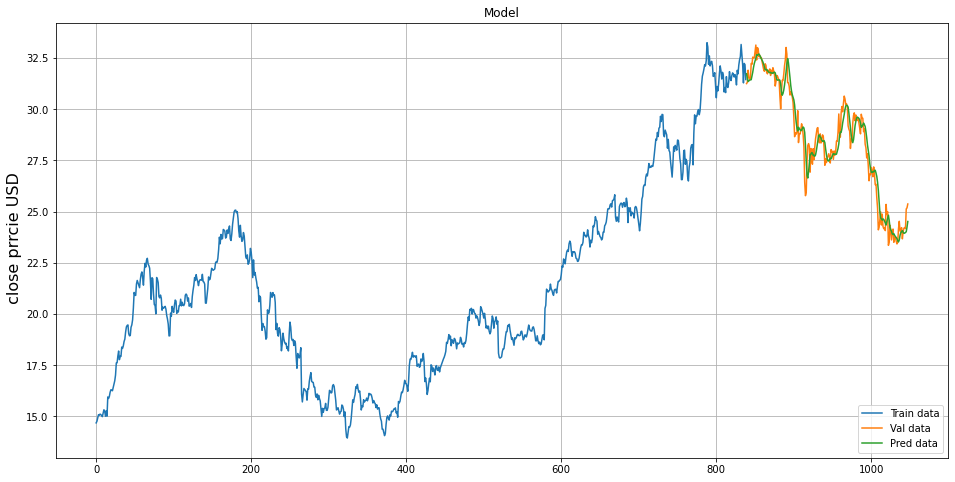

In [55]:
#plotting
train = data[:training_data_len]
valid= data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.ylabel(' close prrcie USD', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train data', 'Val data', 'Pred data'], loc='lower right')
plt.grid()
plt.show()


In [56]:
valid #compare

,Close,Predictions
839,31.252501,31.733454
840,31.315001,31.515957
841,31.905001,31.351114
842,31.580000,31.386501
843,31.467501,31.422857
...,...,...
1043,24.227501,23.950455
1044,24.172501,23.987692
1045,25.132500,24.019096
1046,25.187500,24.245932


In [36]:
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-03-04')
new_df = apple_quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled= scaler.transform(last_60_days)

X_test =  []
X_test.append(last_60_days_scaled)

X_test=np.array(X_test)

X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price=model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/AAPL/history?period1=1325379600&period2=1614905999&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [37]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2021-03-03', end='2021-03-04')
print(apple_quote2['Close'])

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/AAPL/history?period1=1614733200&period2=1614905999&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'